# Looking up a linear type in a provenance graph

In [1]:
from pathlib import Path
import pickle

import pandas as pd
from prov.model import ProvDocument
from prov.graph import prov_to_graph, graph_to_prov

from flatprovenancetypes import print_flat_type, calculate_flat_provenance_types

In [2]:
# point this path to where the provenance graphs are
graphs_path = Path("../datasets/MIMIC-PXC7/")
# point this path to where it can find the kernels' ".picked" files
kernels_path = Path("../outputs/MIMIC-PXC7/kernels/")

In [3]:
# the kernel we want to work with
kernel_id = "FA_2"

## Load a feature table

In [4]:
kernel_file_path = kernels_path / (kernel_id + ".pickled")
features_df = pd.read_pickle(kernel_file_path)

In [5]:
features_df.head()

Number,FA2_1,FA2_2,FA2_3,FA2_4,FA2_5,FA2_6,FA2_7,FA2_8,FA2_9,FA2_10,...,FA2_5657,FA2_5658,FA2_5659,FA2_5660,FA2_5661,FA2_5662,FA2_5663,FA2_5664,FA2_5665,FA2_5666
graph_file,,,,,,,,,,,,,,,,,,,,,
124321.json,1,1,1,1,1,1,1,2,4,1,...,0,0,0,0,0,0,0,0,0,0
144319.json,4,0,2,0,0,1,1,1,7,2,...,0,0,0,0,0,0,0,0,0,0
165660.json,8,1,1,1,0,1,1,2,13,1,...,0,0,0,0,0,0,0,0,0,0
101651.json,1,0,1,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
117876.json,13,1,1,1,0,1,1,2,19,1,...,0,0,0,0,0,0,0,0,0,0


## Load type map for the selected kernel

In [6]:
types_map_filepath = kernels_path / (kernel_id + "_types_map.pickled")
with types_map_filepath.open("rb") as f:
    types_map = pickle.load(f)

In [7]:
prov_type = types_map["FA2_1"]
prov_type

(frozenset({<QualifiedName: mimic:Patient>,
            <QualifiedName: prov:Agent>,
            <QualifiedName: prov:Entity>,
            <QualifiedName: prov:Person>}),
 frozenset({<QualifiedName: prov:Association>,
            <QualifiedName: prov:Derivation>,
            <QualifiedName: prov:Usage>}),
 frozenset({<QualifiedName: prov:Derivation>,
            <QualifiedName: prov:Generation>}))

In [8]:
# to see the pretty-formatted string
print_flat_type(prov_type)

'[der|gen]→[der|usd|waw]→[agt|ent|mimic:Patient|prov:Person]'

## Load a provenance graph

In [9]:
graph_filename = "144319.json"
prov_doc = ProvDocument.deserialize(graphs_path / graph_filename)

In [10]:
# converting the PROV document into a NetworkX graph
# see https://networkx.org/documentation/stable/reference/classes/multidigraph.html
prov_graph = prov_to_graph(prov_doc)

In [11]:
# a view of all the nodes
prov_graph.nodes

NodeView((<ProvAgent: staff:20889>, <ProvAgent: staff:17741>, <ProvAgent: staff:14913>, <ProvAgent: units:7>, <ProvAgent: units:32>, <ProvAgent: units:17>, <ProvEntity: process:224566>, <ProvEntity: process:224277>, <ProvEntity: process:225966>, <ProvEntity: process:224267>, <ProvEntity: process:227194>, <ProvEntity: process:225459>, <ProvEntity: process:225402>, <ProvEntity: patients:34>, <ProvEntity: patients:34/144319.6978720332.0>, <ProvEntity: patients:34/144319.6978720813.0>, <ProvEntity: patients:34/144319.6978722952.0>, <ProvEntity: patients:34/144319.6978857050.0>, <ProvEntity: patients:34/144319.6978946853.0>, <ProvEntity: patients:34/144319.6978731700.0>, <ProvEntity: patients:34/144319.6978857040.0>, <ProvEntity: patients:34/144319.6978731940.0>, <ProvEntity: patients:34/144319.6978732000.0>, <ProvEntity: patients:34/144319.6978738240.0>, <ProvEntity: patients:34/144319.6978817380.0>, <ProvEntity: patients:34/144319.6978742800.0>, <ProvEntity: patients:34/144319.6978742860.

## Construct linear types in the graph

In [12]:
fptypes = calculate_flat_provenance_types(
    prov_doc,  # the ProvDocument object to produce types from
    to_level=2,  # calculate types up to this given level (2)
    including_primitives_types=True,  # also consider application-specific types
)

In [13]:
fptypes.keys()  # all the available levels

dict_keys([0, 1, 2])

In [14]:
# Looking for prov_type in fptypes
for qn, t2 in fptypes[2].items():
    if t2 == prov_type:
        print(qn)
        # stop at the first find
        break

patients:34/144319.6978743520.0


## Extract a sub-graph at a given node

In [15]:
# get the element from the identifier
node = prov_doc.get_record(qn)[0]

In [16]:
# find all the successors of node
successors = prov_graph.successors(node)

In [17]:
list(successors)

[<ProvActivity: procedures:162249>,
 <ProvEntity: patients:34/144319.6978743460.0>]

In [18]:
def successors_at_level(graph, node, level):
    results = set()
    nodes_to_visit = {node}
    for _ in range(level):
        successors = set()
        while nodes_to_visit:
            n = nodes_to_visit.pop()
            successors.update(graph.successors(n))
            results.add(n)
        nodes_to_visit = successors

    # put all nodes in the last layer to results
    results.update(nodes_to_visit)
    return results

In [19]:
successors_at_level(prov_graph, node, 2)

{<ProvActivity: procedures:162249>,
 <ProvAgent: staff:17741>,
 <ProvEntity: patients:34/144319.6978742860.0>,
 <ProvEntity: patients:34/144319.6978743460.0>,
 <ProvEntity: patients:34/144319.6978743520.0>}

In [20]:
# produce a subgraph of node with level away
def produce_sub_graph(graph, node, level: int):
    nodes = successors_at_level(graph, node, level)
    return prov_graph.subgraph(nodes)

### Convert a subgraph back to a PROV document

In [21]:
subgraph_of_node = produce_sub_graph(prov_graph, node, 2)
prov_doc_of_node = graph_to_prov(subgraph_of_node)

In [22]:
print(prov_doc_of_node.get_provn())

document
  prefix procedures <https://mimic.physionet.org/mimiciii/1.4/procedures/>
  prefix process <https://mimic.physionet.org/mimiciii/1.4/process/>
  prefix mimic <https://openprovenance.org/ns/mimic#>
  prefix attrs <https://openprovenance.org/ns/mimic#attr_>
  prefix patients <https://mimic.physionet.org/mimiciii/1.4/patients/>
  prefix staff <https://mimic.physionet.org/mimiciii/1.4/staff/>
  
  activity(procedures:162249, 2191-02-23T11:51:00, 2191-02-23T11:52:00, [prov:type='process:225459', prov:type='mimic:Performing', attrs:category="Imaging", attrs:cat_desc="Electrolytes"])
  entity(patients:34/144319.6978743520.0, [prov:type='mimic:Patient'])
  entity(patients:34/144319.6978743460.0, [prov:type='mimic:Patient'])
  entity(patients:34/144319.6978742860.0, [prov:type='mimic:Patient'])
  agent(staff:17741, [prov:type='prov:Person', prov:label="RN", attrs:description="RN"])
  wasAssociatedWith(procedures:162249, staff:17741, process:225459)
  used(procedures:162249, patients:3

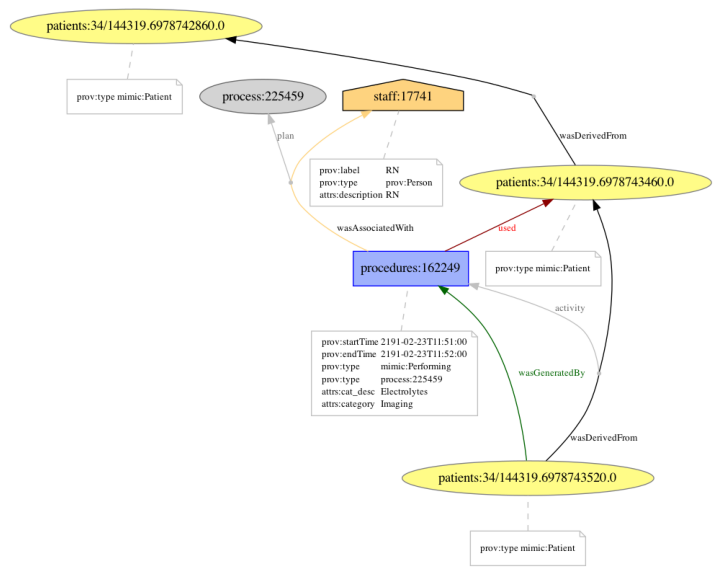

In [23]:
prov_doc_of_node.plot()